In [1]:
%matplotlib inline

import keras
import os
import cv2
import numpy as np
from PIL import Image
import json
import keras.backend as K
import tensorflow as tf
import sklearn.preprocessing
from keras.models import Sequential
from keras import metrics
from keras.layers import Dense, Softmax, Conv2D, Input, Flatten, Lambda, MaxPooling2D, BatchNormalization, Conv2DTranspose, Dropout
from IPython.display import display 
import metricsSemSeg

CLASSTORGB = [[0,0,0],[255,255,255]]
NNName = "xceptionNet"
DATASET = "Seagrass"
CLASSES = 2
BSIZE = 4
X = 256
Y = 128
CLASSWEIGHTS = [0.1, 1.0]
TRAINSIZE = 4223/BSIZE
VALSIZE = 610/BSIZE
TESTSIZE = 1204/BSIZE
TRAINPATH = "images/"
LABELPATH = "ground-truth/"
DATASETPATH = "../data/"+DATASET+"/"
EPOCHS = 100
LR = 0.001
filepath = "../models/keras/"+NNName+str(X)+str(Y)+DATASET+"LR"+str(LR)+"batch"+str(BSIZE)+".h5"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))


# semantic segmentation metrics
class metricsSS(object):

    def __init__(self, num_classes, _bsize):
        super().__init__()
        self.classes = num_classes
        self.batchSize = _bsize
        self.pA = metricsSemSeg.pixel_accuracy
        self.mA = metricsSemSeg.mean_accuracy
        self.mIoU = metricsSemSeg.mean_IU
        self.fwmIoU = metricsSemSeg.frequency_weighted_IU

    def preProcessKerasInput(self, _pred, _true):
            pred = K.argmax(_pred, axis=2)
            true = K.argmax(_true, axis=2)
            #pred = K.cast(pred, tf.float32)
            #true = K.cast(true, tf.float32)
            return pred, true

    def meanIoU(self, y_true, y_pred):
        metric = 0.0
        for b in range(self.batchSize):
            pred, true = self.preProcessKerasInput(y_pred[b], y_true[b])
            metric += tf.py_func(self.mIoU, [pred, true], tf.float32)

        return metric/self.batchSize

    def frequencyWeightedUI(self, y_true, y_pred):
        metric = 0.0
        for b in range(self.batchSize):
            pred, true = self.preProcessKerasInput(y_pred[b], y_true[b])
            metric += tf.py_func(self.fwmIoU, [pred, true], tf.float32)

        return metric/self.batchSize


    def pixelAccuracy(self, y_true, y_pred):
        metric = 0.0
        for b in range(self.batchSize):
            pred, true = self.preProcessKerasInput(y_pred[b], y_true[b])
            metric += tf.py_func(self.pA, [pred, true], tf.float32)

        return metric/self.batchSize


    def meanAccuracy(self, y_true, y_pred):
        metric = 0.0
        for b in range(self.batchSize):
            pred, true = self.preProcessKerasInput(y_pred[b], y_true[b])
            metric += tf.py_func(self.mA, [pred, true], tf.float32)

        return metric/self.batchSize


##################### Pixel Deconvolution
# This module realizes the three methods proposed in paper
# [Pixel Deconvolutional Networks] (https://arxiv.org/abs/1705.06820)
# https://github.com/HongyangGao/PixelDCN/blob/master/utils/pixel_dcn.py


def pixel_dcl(inputs, out_num, kernel_size, scope, activation_fn=tf.nn.relu,
              d_format='NHWC'):
    """
    inputs: input tensor
    out_num: output channel number
    kernel_size: convolutional kernel size
    scope: operation scope
    activation_fn: activation function, could be None if needed
    """
    
    axis = (d_format.index('H'), d_format.index('W'))
    conv0 = conv2d(inputs, out_num, kernel_size,
                   scope+'/conv0', d_format=d_format)
    conv1 = conv2d(conv0, out_num, kernel_size,
                   scope+'/conv1', d_format=d_format)
    dilated_conv0 = dilate_tensor(conv0, axis, (0, 0), scope+'/dialte_conv0')
    dilated_conv1 = dilate_tensor(conv1, axis, (1, 1), scope+'/dialte_conv1')
    conv1 = tf.add(dilated_conv0, dilated_conv1, scope+'/add1')
    with tf.variable_scope(scope+'/conv2'):
        shape = list(kernel_size) + [out_num, out_num]
        weights = tf.get_variable(
            'weights', shape, initializer=tf.contrib.layers.xavier_initializer())
        weights = tf.multiply(weights, get_mask(shape, scope))
        strides = [1, 1, 1, 1]
        conv2 = tf.nn.conv2d(conv1, weights, strides, padding='SAME',
                             data_format=d_format)
        conv2 = Conv2D(
                weights,
                strides=stride,
                padding='same',
                data_format="channels_last"
                )
        conv2.input = conv1
        
    outputs = tf.add(conv1, conv2.output, name=scope+'/add2')
    if activation_fn:
        outputs = activation_fn(outputs)
    return outputs


def combine(tensors, action, axis, name):
    if action == 'concat':
        return tf.concat(tensors, axis, name=name)
    else:
        return tf.add_n(tensors, name=name)

def conv2d(inputs, out_num, kernel_size, scope, stride=1, d_format='NHWC'):
    #outputs = tf.contrib.layers.conv2d(
    #    inputs, out_num, kernel_size, scope=scope, stride=stride,
    #    data_format=d_format, activation_fn=None, biases_initializer=None)
    
    outputs = Conv2D(
                out_num,
                kernel_size,
                strides=stride,
                padding='same',
                data_format="channels_last",
                use_bias=False,
                kernel_initializer='glorot_uniform'
                )
    outputs.input = inputs
    
    return outputs.output


def conv3d(inputs, out_num, kernel_size, scope):
    shape = list(kernel_size) + [inputs.shape[-1].value, out_num]
    weights = tf.get_variable(
        scope+'/conv/weights', shape, initializer=tf.truncated_normal_initializer())
    #outputs = tf.nn.conv3d(
    #    inputs, weights, (1, 1, 1, 1, 1), padding='SAME', name=scope+'/conv')
    
    outputs = keras.layers.Conv3D(
        weights,
        strides=(1, 1, 1, 1, 1),
        padding='same'
        )
    
    outputs.input = inputs
    return outputs.output


def get_mask(shape, scope):
    new_shape = (np.prod(shape[:-2]), shape[-2], shape[-1])
    mask = np.ones(new_shape, dtype=np.float32)
    for i in range(0, new_shape[0], 2):
        mask[i, :, :] = 0
    mask = np.reshape(mask, shape, 'F')
    return tf.constant(mask, dtype=tf.float32, name=scope+'/mask')


def dilate_tensor(inputs, axes, shifts, scope):
    for index, axis in enumerate(axes):
        eles = tf.unstack(inputs, axis=axis, name=scope+'/unstack%s' % index)
        zeros = tf.zeros_like(
            eles[0], dtype=tf.float32, name=scope+'/zeros%s' % index)
        for ele_index in range(len(eles), 0, -1):
            eles.insert(ele_index-shifts[index], zeros)
        inputs = tf.stack(eles, axis=axis, name=scope+'/stack%s' % index)
    return inputs


def shift_tensor(inputs, axes, row_shift, column_shift, scope):
    if row_shift:
        rows = tf.unstack(inputs, axis=axes[0], name=scope+'/rowsunstack')
        row_zeros = tf.zeros_like(
            rows[0], dtype=tf.float32, name=scope+'/rowzeros')
        rows = rows[row_shift:] + [row_zeros]*row_shift
        inputs = tf.stack(rows, axis=axes[0], name=scope+'/rowsstack')
    if column_shift:
        columns = tf.unstack(
            inputs, axis=axes[1], name=scope+'/columnsunstack')
        columns_zeros = tf.zeros_like(
            columns[0], dtype=tf.float32, name=scope+'/columnzeros')
        columns = columns[column_shift:] + [columns_zeros]*column_shift
        inputs = tf.stack(columns, axis=axes[1], name=scope+'/columnsstack')
    return inputs


def pixelDeconv(x, depth, scope):
    return pixel_dcl(x, depth, [3,3], scope)

def convS(f, model):
    model.add(Conv2D(f, 3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout())
    
def deconv(f, model):
    model.add(Conv2DTranspose(f, 3, strides=2, padding='same', activation="relu"))


def conv(first=False, units=128, f=3, dilation=1, last=False):
    if first :  
        return Conv2D(
            units,
            f,
            input_shape=(Y, X, 3),
            strides=(1, 1),
            padding='same',
            activation="relu" if not last else "softmax",
            use_bias=True,
            dilation_rate=dilation,
            data_format="channels_last",
            kernel_initializer="glorot_normal",
            bias_initializer=keras.initializers.Constant(value=0.1)
        )
    else:
        return Conv2D(
            units if not last else CLASSES,
            3 if not last else 1,
            strides=(1, 1),
            padding='same',
            activation="relu",
            use_bias=True,
            data_format="channels_last",
            kernel_initializer="glorot_normal",
            bias_initializer=keras.initializers.Constant(value=0.1)
        )

def deConv(depth):
    return Conv2DTranspose(
        depth,
        3,
        strides=(2, 2),
        padding='same',
        data_format="channels_last",
        kernel_initializer="glorot_normal",
        bias_initializer=keras.initializers.Constant(value=0.1)
    )

    
def netFCN():
    model = Sequential()
    # layers
    # encoding
    model.add(conv(first=True))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))


    model.add(conv(units=128))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))

    model.add(conv(units=256))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))
    
    model.add(conv(units=512))
    L = BatchNormalization()
    model.add(L)

    # decoding
    model.add(deConv(512))
    model.add(deConv(256))
    #model.add(deConv(128))
    #model.add(keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
    #model.add(keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))

    #L = Lambda(lambda input: pixelDeconv(tf.convert_to_tensor(input), 512, "dec1"))
    #model.add(L)
    #L = Lambda(lambda input: pixelDeconv(tf.convert_to_tensor(input), 256, "dec2"))
    #model.add(L)
    #L = Lambda(pixelDeconv(L.output, 128, "dec3"))
    #model.add(L)
    
    #model.add(Dropout(0.5))
    model.add(conv(last=True))
    model.add(Softmax())

    return model

def dilNet():
    model = Sequential()

    model.add(conv(first=True))
    model.add(conv(units=128))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(conv(units=128))
    model.add(conv(units=256))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
        
    model.add(conv(units=256))
    model.add(conv(units=256))
    model.add(conv(units=256, f=1))
    model.add(BatchNormalization())

    model.add(conv(units=512, dilation=2))
    model.add(conv(units=512, dilation=2))
    model.add(conv(units=512, f=1, dilation=2))
    model.add(BatchNormalization())

    model.add(conv(units=512, dilation=4))
    model.add(conv(units=512, dilation=4))
    model.add(conv(units=512, f=1, dilation=4))
    model.add(BatchNormalization())

    model.add(deConv(512))
    model.add(deConv(256))

    #model.add(keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
    #model.add(keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))

    model.add(conv(last=True))
    model.add(Softmax())    
    return model

def mobileNet_V2_SS(inputShape):
    model = Sequential()
    model.add(keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=inputShape,
        alpha=1.0,
        depth_multiplier=1,
        include_top=False,
        weights=None
        
    ))
    
    deconv(320, model)
    deconv(256, model)
    deconv(256, model)
    deconv(256, model)
    deconv(128, model)
    model.add(conv(last=True))
    model.add(Softmax())
    
    return model



def inceptionResnet_SS(inputShape):
    model = Sequential()
    model.add(keras.applications.inception_resnet_v2.InceptionResNetV2(
        input_shape=inputShape,
        include_top=False,
        weights=None
    ))
    
    deconv(320, model)
    deconv(256, model)
    deconv(256, model)
    deconv(256, model)
    deconv(128, model)
    model.add(conv(last=True))
    model.add(Softmax())
    
    return model
              
def xception_SS(inputShape):
    model = Sequential()
    model.add(keras.applications.xception.Xception(
        input_shape=inputShape,
        include_top=False,
        weights=None
    ))
    
    deconv(320, model)
    deconv(256, model)
    deconv(256, model)
    deconv(256, model)
    deconv(128, model)
    model.add(conv(last=True))
    model.add(Softmax())
    
    return model
              
def nasNet_SS(inputShape):
    model = Sequential()
    model.add(keras.applications.nasnet.NASNetLarge(
        input_shape=inputShape,
        include_top=False,
        weights=None
    ))
    
    deconv(320, model)
    deconv(256, model)
    deconv(256, model)
    deconv(256, model)
    deconv(128, model)
    convS(CLASSES, model)
    model.add(Softmax())
    
    return model

class DataSequence(keras.utils.Sequence):

    def __init__(self, batchSize, trainType):
        self.dataSetPath = DATASETPATH
        
        if trainType == "train":
            jsonData = json.load(open(DATASETPATH+"train.json"))
            self.x = list(map(lambda i:os.path.basename(i["image"]) if i["depth"] <= float(6) else None, jsonData))
            self.y = list(map(lambda i:os.path.basename(i["ground-truth"]) if i["depth"] <= float(6) else None, jsonData))
            TRAINSIZE = len(self.x)
            
            
        elif trainType == "validation":
            jsonData = json.load(open(DATASETPATH+"test.json"))
            self.x = list(map(lambda i:os.path.basename(i["image"]), jsonData))
            self.y = list(map(lambda i:os.path.basename(i["ground-truth"]), jsonData))
            VALSIZE = len(self.x)
        
        elif trainType == "test":
            jsonData = json.load(open(DATASETPATH+"validate.json"))
            self.x = list(map(lambda i:os.path.basename(i["image"]), jsonData))
            self.y = list(map(lambda i:os.path.basename(i["ground-truth"]), jsonData))
            TESTSIZE = len(self.x)
        
        else:
            raise "unknown dataset type, valid are train, validation and test"
    
        
        self.batch_size = batchSize

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        imgBatch = None
        labelImgBatch = None
        
        for b in range(self.batch_size):
            #  loading train and label image
            img = cv2.imread(self.dataSetPath+TRAINPATH+self.x[idx+b])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (X, Y), interpolation=cv2.INTER_NEAREST)

            labelImg = cv2.imread(self.dataSetPath+LABELPATH+self.y[idx+b])
            labelImg = cv2.cvtColor(labelImg, cv2.COLOR_BGR2RGB)
            labelImg = cv2.resize(labelImg, (X, Y), interpolation=cv2.INTER_NEAREST)


           # if CLASSES == 2:
            #    labelImg[(labelImg  >= 128).all(-1)] = [255,255,255]
             #   labelImg[(labelImg  <= 127).all(-1)] = [0,0,0]


            #print(self.dataSetPath+TRAINPATH+self.x[idx], self.dataSetPath+LABELPATH+self.y[idx])
            #display(Image.fromarray(img, "RGB"))
            #display(Image.fromarray(labelImg, "RGB"))

            # process train and label image
            img = ((img - img.mean()) / img.std()).astype(np.float32)
            img = np.array(img)
            img = np.reshape(img, (1,Y,X,3))



            for rgbIdx, rgbV in enumerate(CLASSTORGB):
                labelImg[(labelImg == rgbV).all(-1)] = rgbIdx


            labelImg = labelImg[:,:,0].astype(np.int32)
            labelImg = np.reshape(labelImg, (1,Y,X,1))


            # dont know why but there are(some datasets) rgb values which are not assigned to a class
            # because of this these values are not replaced with their assigned class and
            # have to be removed as in assigned to class zero aka black
            #print("UNIQUE RGB VALUES", np.unique(np.array(img).reshape((int(6291456/3), 3)), axis=0))

            labelImg[(labelImg >= CLASSES)] = 0

            #onehot = keras.utils.to_categorical(labelImg, num_classes=2, dtype='float32')
            #print(img.shape, labelImg.shape)
            #calculcate the weights for the current image
            #sampleWeights = onehot * [0.1, 1.0]
            #sampleWeights = np.sum(sampleWeights, axis=3)
            #sampleWeights = sampleWeights.reshape((self.batch_size,224,224,1))
        
            if imgBatch is None:
                imgBatch = img
                labelImgBatch = labelImg
            else:
                imgBatch = np.concatenate((imgBatch, img), axis=0)
                labelImgBatch = np.concatenate((labelImgBatch, labelImg), axis=0)
            
        return imgBatch, labelImgBatch#, sampleWeights
    

    
def pred(fileName, debug=True):
    predImg = cv2.imread("../results/"+fileName)
    predImg = cv2.cvtColor(predImg, cv2.COLOR_BGR2RGB)
    predImg = cv2.resize(predImg, (X, Y), interpolation=cv2.INTER_NEAREST)
    predImg = np.expand_dims(((predImg  - predImg.mean()) / predImg.std()).astype(np.float32), axis=0)
    predClasses = model.predict(predImg)
    predClasses = np.argmax(predClasses, axis=3).flatten()
    #print(predClasses.shape, np.bincount(predClasses), predClasses)
    predImg = np.zeros((X*Y,3))

    for idx, p in enumerate(predClasses):
        predImg[idx] = CLASSTORGB[p]
         
   
    predImg = predImg.reshape((Y, X, 3)).astype("uint8")
    
    if debug:
        display(Image.fromarray(predImg, "RGB"))
        
class regularPred(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        pred("predictSeagrass.jpg")

    #def on_batch_end(self, batch, logs={}):
    #    if batch % 500 == 0:
    #        pred("predict.jpg")
        
    
# in case class weights are needed
def sparse_crossentropy_weighted(ground_truth, predictions):
    
    ground_truth = tf.cast(ground_truth, tf.int32)
        
    #onehot_labels = tf.one_hot(tf.squeeze(ground_truth,3), CLASSES)
    #weights = onehot_labels * CLASSWEIGHTS
    #weights = tf.reduce_sum(weights, 3)
    
    return tf.reduce_mean(
        tf.losses.sparse_softmax_cross_entropy(
                        labels=ground_truth,
                        logits=predictions))
     #                   weights=weights))

def getModel(modelName):
    import os
    from keras.models import load_model

    metricsPA = metricsSS(CLASSES, BSIZE).pixelAccuracy
    metricsMA = metricsSS(CLASSES, BSIZE).meanAccuracy
    metricsMIOU = metricsSS(CLASSES, BSIZE).meanIoU
    metricsFWMIOU = metricsSS(CLASSES, BSIZE).frequencyWeightedUI
    
    if os.path.isfile(filepath):
        model = load_model(filepath, custom_objects={
                                        "sparse_crossentropy_weighted":sparse_crossentropy_weighted,
                                        'pixelAccuracy': metricsPA,
                                        "meanAccuracy": metricsMA,
                                        "meanIoU": metricsMIOU,
                                        "frequencyWeightedUI": metricsFWMIOU
                                    }
                          )

        print("Model loaded from h5 file")
    else:
        if modelName == "deeplabv3":
            from nets.deepLabv3Keras import Deeplabv3
            model = Deeplabv3(weights=None, backbone="xception", input_shape=(Y,X,3), classes=CLASSES, OS=8)  
        elif modelName == "mobilenetv2":
            model = mobileNet_V2_SS((Y,X,3))
        elif modelName =="FCN":
            model = netFCN()
        elif modelName =="dilNet":
            model = dilNet()
        elif modelName =="NASNet":
            model = nasNet_SS((Y,X,3))
        elif modelName =="inceptionresnetNet":
            model = inceptionResnet_SS((Y,X,3))
        elif modelName =="xceptionNet":
            model = xception_SS((Y,X,3)) 
        else:
            raise "no right modelname given"

        print("Fresh model loaded from architecture")
        
    return model

Using TensorFlow backend.


Model loaded from h5 file
Model compiled...
Epoch 1/100
1056/1055 [==============================] - 114s 108ms/step - loss: 0.3576 - val_loss: 0.3687


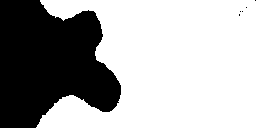


Epoch 00001: val_loss improved from inf to 0.36866, saving model to ../models/keras/xceptionNet256128SeagrassLR0.001batch4.h5
Epoch 2/100
 604/1055 [================>.............] - ETA: 41s - loss: 0.3440

In [ ]:
%matplotlib inline



model = getModel(NNName)
        
#model.summary()
model.compile(
                loss=sparse_crossentropy_weighted,
                optimizer=keras.optimizers.Nadam(lr=LR),
                metrics=[]
            )

print("Model compiled...")

modelCheckpointer = keras.callbacks.ModelCheckpoint(
                                    filepath,
                                    monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='min',
                                    period=1)

earlyStopper = keras.callbacks.EarlyStopping(
                                          monitor='val_loss',
                                          min_delta=0.0001,
                                          patience=10,
                                          verbose=1,
                                          mode='min'
                                    )
lrReducer = keras.callbacks.ReduceLROnPlateau(
                                    monitor='val_loss',
                                    factor=0.1,
                                    patience=5,
                                    verbose=1,
                                    mode="min",
                                    min_delta=0.0001,
                                    cooldown=0,
                                    min_lr=0)

history = model.fit_generator(
        DataSequence(BSIZE, "train"),
        steps_per_epoch=TRAINSIZE,
        epochs=EPOCHS,
        verbose=1,
        use_multiprocessing=True,
        shuffle=True,
        validation_data=DataSequence(BSIZE,"validation"),
        validation_steps=VALSIZE,
        callbacks=[
            regularPred(),
            modelCheckpointer,
            earlyStopper,
            lrReducer
            ]
)



testloss = model.evaluate_generator(
    DataSequence(BSIZE,"test"),
    steps=TESTSIZE,
    use_multiprocessing=True,
    verbose=1
)

print(testloss)
model.save("lastModel"+filepath)
print("Last model saved....")

In [ ]:
from data import Data
from metricsSemSeg import pixel_accuracy, mean_accuracy, mean_IU, frequency_weighted_IU

config = json.load(open("nets/netFCNConfig.json"))
# load data object initially which provides training and test data loader
data = Data("../data/"+DATASET+"/configData"+DATASET+".json")
totalCorrect = 0
totalCount = TESTSIZE*X*Y*3

totalPAcc = 0.0
totalMAcc = 0.0
totalMIU = 0.0
totalFWIU = 0.0

i = 0
model = getModel(NNName)

for labelData, imgData in data.getNextBatchTest(BSIZE, TESTSIZE*BSIZE):

    # upper = config["batchSize"]*i
    # lower = config["batchSize"]*(i-1)  

    # if upper <= totalTestCount:
    #     images = imgData[lower:upper]
    #     labels = labelData[lower:upper]

    #     totalCount += labels.size
    
        print(imgData.shape, labelData.shape)

        predClasses = model.predict_on_batch(imgData)

        predClasses = np.squeeze(predClasses[0])
        predClasses = np.argmax(predClasses, axis=2)
        labelData = np.squeeze(labelData[0])
        
        if i % 100/BSIZE == 0:
            print("Image ", i, " evaluated...")

        #print(predClasses.shape, labelData.shape)

        totalPAcc = pixel_accuracy(predClasses, labelData) if totalPAcc == 0.0 else  (totalPAcc + pixel_accuracy(predClasses, labelData))/2
        totalMAcc = mean_accuracy(predClasses, labelData) if totalMAcc == 0.0 else  (totalMAcc + mean_accuracy(predClasses, labelData))/2
        totalMIU = mean_IU(predClasses, labelData) if totalMIU == 0.0 else  (totalMIU + mean_IU(predClasses, labelData))/2
        totalFWIU = frequency_weighted_IU(predClasses, labelData) if totalFWIU == 0.0 else  (totalFWIU + frequency_weighted_IU(predClasses, labelData))/2

        i = i+1

print("Pixel accuracy: ", totalPAcc ," || Mean accuracy: ", totalMAcc ," || Mean intersection union:", totalMIU ," || frequency weighted IU: ", totalFWIU)

In [ ]:

#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import matplotlib.pyplot as plt
# summarize history for accuracy
#plt.plot(history.history['pixelAccuracy'])
#plt.plot(history.history['val_pixelAccuracy'])
#plt.title('pixel accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train',"val"], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', "val"], loc='upper left')
plt.show()
# summarize history for mean iou
#plt.plot(history.history['meanIoU'])
#plt.plot(history.history['val_meanIoU'])
#plt.title('model mean IoU')
#plt.ylabel('mean_iou')
#plt.xlabel('epoch')
#plt.legend(['train', "val"], loc='upper left')
#plt.show()
#plt.plot(history.history['meanAccuracy'])
#plt.plot(history.history['val_meanAccuracy'])
#plt.title('model meanAccuracy')
#plt.ylabel('meanAccuracy')
#plt.xlabel('epoch')
#plt.legend(['train', "val"], loc='upper left')
#plt.show()
#plt.plot(history.history['frequencyWeightedUI'])
#plt.plot(history.history['val_frequencyWeightedUI'])
#plt.title('model frequencyWeightedUI')
#plt.ylabel('frequencyWeightedUI')
#plt.xlabel('epoch')
#plt.legend(['train', "val"], loc='upper left')
#plt.show()